In [1]:
import sys
from numba import jit
import numpy as np
import timeit
polymerLenght = 10
headN = 1

# DEFINE SYSTEM

def polymergenerator(polymerl, headl):
    COM = [5, 2.5, 0.60]                         # centre of mass for the particle
    polymer = np.array((range(polymerl), np.zeros(polymerl), np.zeros(polymerl))).T  # create linear polymer
    polymersurface = polymer + [0,0.5,0]
    headsurface = np.array((COM,COM,COM,COM))
    headsurface += np.array([[0.1,0,0],[0,0.1,0],[-0.1,0,0],[0,-0.1,0.0]]) # create surface domains aorund COM
    return polymer, polymersurface, COM, headsurface

"""# DEFINE FORCES
def lj(a, b, epsilon=0.2, sigma=1.0, mass = 1, random = 0.1, random_forces_summ = random_forces_sum):
    dif = a - b
    dist = np.sqrt(np.sum(np.square(dif), axis=1))
    f = 24 * epsilon * (-2*(sigma**12 / dist**13) + (sigma**6 / dist**7))
    vector = dif / np.array((dist, dist, dist)).T
    random_forces = np.random.uniform(-random, random, (3,))
    forcevector = np.sum(vector * np.array((f, f, f)).T, axis=0) + random_forces
    random_forces_summ += random_forces
    # a = forcevector/mass 
    return forcevector, random_forces_summ
    
    
# DEFINE INTEGRATION ALG
def verlet(positions, velocities, accelerations, dt, random):
    positions = positions + velocities * dt + (accelerations/2) * (dt**2)
    accelerationst1, random_forces_summ = lj(polymer, positions, random = random)
    velocities =  velocities + (accelerationst1 + accelerations) * (dt/2)
    return positions, velocities, accelerationst1, random_forces_summ
"""

def lj_brownian(a, b, epsilon=0.1, sigma=2):
    dif = a - b
    dist = np.sqrt(np.sum(np.square(dif), axis=1))
    f = 24 * epsilon * (-2*(sigma**12 / dist**13))  + (sigma**6 / dist**7)
    vector = dif / np.array((dist, dist, dist)).T
    forcevector = np.sum(vector * np.array((f, f, f)).T, axis=0)
    return forcevector

def lj_repulsive(a, b, epsilon=0.1, sigma=2):
    dif = a - b
    dist = np.sqrt(np.sum(np.square(dif), axis=1))
    f = 24 * epsilon * (-2*(sigma**12 / dist**13))
    vector = dif / np.array((dist, dist, dist)).T
    forcevector = np.sum(vector * np.array((f, f, f)).T, axis=0)
    return forcevector

def harmonic_angle(surface, COM, n, theta=np.pi/2, K=2.0, random=0.1):
    ab = surface - COM
    bc = np.roll(surface, n, axis=0) - COM
    ab_norm = np.linalg.norm(ab, axis=1)   # shape: (N-1,)
    bc_norm = np.linalg.norm(bc, axis=1)   # shape: (N-1,)
    cos_angle = np.sum(ab * bc, axis=1) / (ab_norm * bc_norm)
    cos_angle = np.clip(cos_angle, -1, 1)
    angle_diff = theta - np.arccos(cos_angle)   # shape: (N-1,)
    cross_inner = np.cross(bc, ab)   # shape: (N-1, 3)
    vector = np.cross(ab, cross_inner)  # shape: (N-1, 3)
    vec_norm = np.linalg.norm(vector, axis=1)  # shape: (N-1,)
    with np.errstate(divide='ignore', invalid='ignore'):
        force = -2 * K * angle_diff[:, np.newaxis] * vector / vec_norm[:, np.newaxis]
        force[vec_norm == 0] = 0
    return force
    

       
def harmonic_surface(surface, COM, epsilon=1, sigma=0.1, random=0.1):
    ab = surface - COM
    ab_norm = np.linalg.norm(ab, axis=1)
    force = 2*epsilon*(sigma-ab_norm)[:,np.newaxis]*ab/ab_norm[:, np.newaxis]
    return force


def notverlet(COM, surface, dt, random, mu = 1, diagnostics = False):
    #random_forces = np.random.uniform(-random, random, (3,))
    angle_forces = harmonic_angle(surface, COM, 1) + harmonic_angle(surface, COM, -1) + harmonic_angle(surface, COM, 2, np.pi)
    if diagnostics: print(angle_forces, COM)
    harmonic_bond = harmonic_surface(surface, COM)
    surface = surface + (mu*(angle_forces + harmonic_bond + np.array(([0,0,0],[0,0,0],lj_brownian(polymersurface,surface[3],0.1,0.02),[0,0,0])))+0.001*np.random.uniform(-random, random, (4,3)))*dt
    COM = COM + (mu * (lj_repulsive(polymer, COM, epsilon = 0.1, sigma=0.5) - np.sum(harmonic_bond, axis=0) - np.sum(angle_forces)) + np.random.uniform(-random, random, (3,))) * dt
    return COM, surface


In [2]:
polymer, polymersurface, COMx, surfacex = polymergenerator(polymerLenght, headN)
seed = 1
steps = 5000
print_every = 10000

#track history positions, velocities and accelerations 
headhist = np.zeros((int(steps), 3))
surfacehist = np.zeros((int(steps), 4, 3))
headhist[0] = COMx
surfacehist[0] = surfacex

# RUN
for i in range(steps):
    if i == 0: diagnostics_tiemstep = True
    else: diagnostics_tiemstep = False
    COMx, surfacex = notverlet(COMx,surfacex, 0.01, random = 0.01, diagnostics = diagnostics_tiemstep)
    if i%print_every == 0: print(i, COMx) # sanity check output to console
    headhist[i] = COMx
    surfacehist[i] = surfacex

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] [5, 2.5, 0.6]
0 [5.00005271 2.50003984 0.60009861]


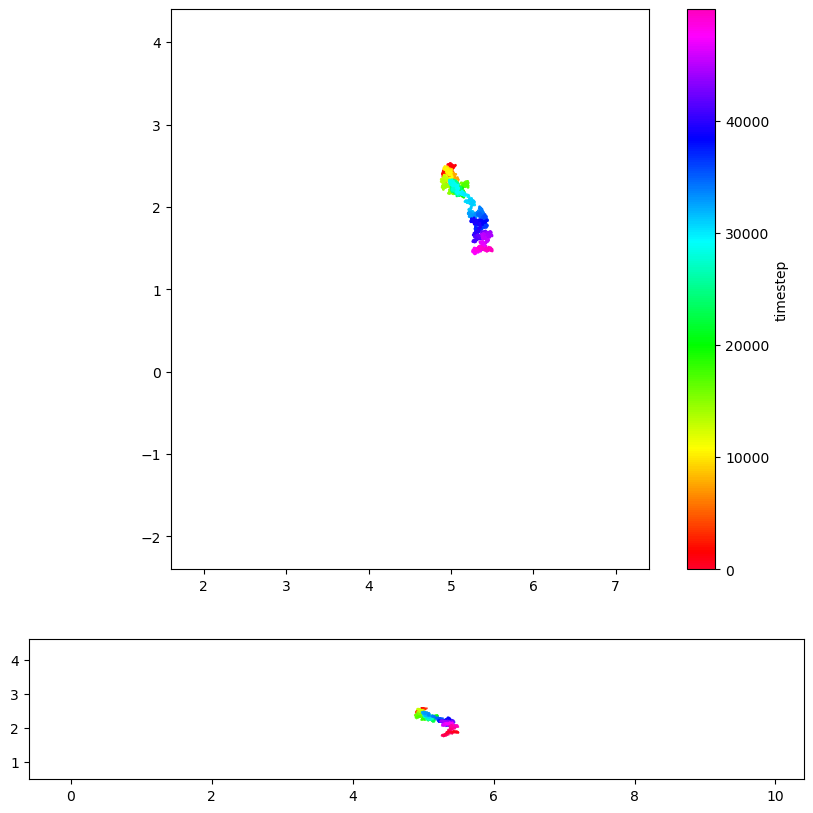

In [17]:
import matplotlib.pyplot as plt
orthogonal_distance = np.linalg.norm(headhist[::20,1:], axis=1)

time = np.arange(steps)
fig, ax = plt.subplots(2,gridspec_kw={'height_ratios': [4, 1], "width_ratios": [1]}, figsize=(10,10))
pos = ax[0].scatter(headhist[::20,0], headhist[::20,1], cmap="gist_rainbow", c=time[::20], s=1)
ax[0].set_xlim(1.6, 7.4)
ax[0].set_ylim(-2.4, 4.4)
ax[0].set_aspect("equal", adjustable="box")
perp = ax[1].scatter(headhist[::20,0], orthogonal_distance , cmap="hsv", c=time[::20], s=0.1)
ax[1].set_xlim(-0.6, 10.4)
ax[1].set_ylim(0.5, 4.6)
fig.colorbar(pos, label='timestep')

In [219]:
"""with open("trajectory.pdb", "w") as f:
    for t, positions in enumerate(headhist[::200]):  # Save every 100th frame
        f.write(f"MODEL     {t + 1}\n")
        f.write(f"ATOM  {1:5d}  C   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {1:5d}  CA   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {1:5d}  CB   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {1:5d}  S   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           S\n")
        f.write(f"ATOM  {1:5d}  N   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           N\n")
        f.write("ENDMDL\n")
        """

'with open("trajectory.pdb", "w") as f:\n    for t, positions in enumerate(headhist[::200]):  # Save every 100th frame\n        f.write(f"MODEL     {t + 1}\n")\n        f.write(f"ATOM  {1:5d}  C   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           C\n")\n        f.write(f"ATOM  {1:5d}  CA   UNK     1    {surface[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           C\n")\n        f.write(f"ATOM  {1:5d}  CB   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           C\n")\n        f.write(f"ATOM  {1:5d}  S   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           S\n")\n        f.write(f"ATOM  {1:5d}  N   UNK     1    {positions[0]:8.3f}{positions[1]:8.3f}{positions[2]:8.3f}  1.00  0.00           N\n")\n        f.write("ENDMDL\n")'

In [11]:
with open("trajectory.pdb", "w") as f:
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::100],(500,1,3))), surfacehist[::100]),axis=1)):  # Save every 100th frame
        f.write(f"MODEL     {t + 1}\n")
        f.write(f"ATOM  {1:5d}  C   UNK     1    {positions[0,0]:8.3f}{positions[0,1]:8.3f}{positions[0,2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {2:5d}  CA   UNK     1    {positions[1,0]:8.3f}{positions[1,1]:8.3f}{positions[1,2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {3:5d}  CB   UNK     1    {positions[2,0]:8.3f}{positions[2,1]:8.3f}{positions[2,2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {4:5d}  O   UNK     1    {positions[3,0]:8.3f}{positions[3,1]:8.3f}{positions[3,2]:8.3f}  1.00  0.00           O\n")
        f.write(f"ATOM  {5:5d}  N   UNK     1    {positions[4,0]:8.3f}{positions[4,1]:8.3f}{positions[4,2]:8.3f}  1.00  0.00           N\n")
        f.write("ENDMDL\n")

In [12]:
with open("polymerr.pdb", "w") as f:
    for i in range(polymerLenght):
        f.write(f"ATOM  {i+2:5d}  C   UNK     1    {i:8.3f}{0:8.3f}{0:8.3f}  1.00  0.00           C\n")

In [21]:
with open("trajectory.xyz", "w") as f:
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::100],(500,1,3))), surfacehist[::100]),axis=1)):
        f.write(f"5 \n \n")
        f.write(f"C1 {positions[0,0]:8.3f}{positions[0,1]:8.3f}{positions[0,2]:8.3f} \n")
        f.write(f"C2 {positions[1,0]:8.3f}{positions[1,1]:8.3f}{positions[1,2]:8.3f} \n")
        f.write(f"C3 {positions[2,0]:8.3f}{positions[2,1]:8.3f}{positions[2,2]:8.3f} \n")
        f.write(f"C4 {positions[3,0]:8.3f}{positions[3,1]:8.3f}{positions[3,2]:8.3f} \n")
        f.write(f"C5 {positions[4,0]:8.3f}{positions[4,1]:8.3f}{positions[4,2]:8.3f} \n")

In [12]:
np.linalg.norm(surfacehist[-1]-headhist[-1], axis=1)

array([0.12727554, 0.13525558, 0.1080009 , 0.10014226])

In [13]:
surface_test = np.array([[5.10976304, 2.49865677, 0.59131925],
       [5.00296914, 2.59107846, 0.59861942],
       [4.89298207, 2.49376377, 0.5964134 ],
       [4.99730706, 2.39156799, 0.59120903]])

In [22]:
notverlet(COMx, surface_test ,0.01, 0)

(array([5.00004662, 2.49962828, 0.59996574]),
 array([[5.10993573, 2.50037282, 0.59580312],
        [4.99820618, 2.59146838, 0.6023985 ],
        [4.89239831, 2.50357644, 0.60111204],
        [5.00065273, 2.39134463, 0.59512305]]))

In [9]:
COMx

array([4.98969646, 2.50535137, 0.60989463])

In [3]:
surfacex.shape

(4, 3)